In [1]:
import gymnasium as gym
import numpy as np
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical, Normal, MultivariateNormal
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [2]:
import gc
gc.collect()

0

In [3]:
!nvidia-smi
# clean up memory forcefully
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



Sat Apr 20 13:48:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
| 41%   66C    P2             229W / 250W |   1392MiB / 11264MiB |     68%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

import torch
import torch.nn as nn
import torch.nn.functional as F

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, init_w=3e-3):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        
        self.mu = nn.Linear(32, output_dim)
        self.fc_cov = nn.Linear(32, output_dim * (output_dim + 1) // 2)

        
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        self.mu.weight.data.uniform_(-init_w, init_w)
        self.mu.bias.data.uniform_(-init_w, init_w)
        self.fc_cov.weight.data.uniform_(-init_w, init_w)
        self.fc_cov.bias.data.uniform_(-init_w, init_w)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        mu = self.mu(x)
        
        cov_params = self.fc_cov(x)
        
        L = torch.zeros((x.size(0), mu.size(1), mu.size(1)), device=x.device)
        indices = torch.tril_indices(mu.size(1), mu.size(1))
        L[:, indices[0], indices[1]] = cov_params
        L[:, range(mu.size(1)), range(mu.size(1))] = F.softplus(L[:, range(mu.size(1)), range(mu.size(1))])
        
        cov = L @ L.transpose(-1, -2)
        
        return mu,cov


Using device: cuda


In [5]:
from imitation.util.util import make_vec_env

observations= np.load("../dataset/obs.npy", allow_pickle=True)
actions = np.load("../dataset/actions.npy", allow_pickle=True)
rewards = np.load("../dataset/rewards.npy", allow_pickle=True)
dones = np.load("../dataset/dones.npy", allow_pickle=True)
info = np.load("../dataset/info.npy", allow_pickle=True)
next_obs = np.load("../dataset/next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()

print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])
env = make_vec_env(
    "seals:seals/Walker2d-v1",
    rng=np.random.default_rng(),
    env_make_kwargs={"render_mode": "rgb_array"},
    n_envs=1,
)

(100000, 18) (100000, 6) (100000,) (100000,) (100000,) (100000, 18)
[ 1.36961687e-03  1.24769787e+00 -4.59026476e-03 -4.83472364e-03
  3.13270239e-03  4.12755577e-03  1.06635776e-03  2.29496561e-03
  4.36249915e-04  4.35072424e-03  3.15853554e-03 -4.97261500e-03
  3.57404277e-03 -4.66414425e-03  2.29655446e-03 -3.24344379e-03
  3.63178922e-03  4.14612202e-04] [1.        1.        0.9766268 1.        0.1786359 1.       ] 1.1278079 False {'x_position': 0.002431965734592546, 'x_velocity': 0.13279360767225037, 'TimeLimit.truncated': False} [ 2.43196573e-03  1.24594578e+00 -8.64441604e-04 -1.14463408e-03
  3.10100134e-03  5.86868264e-02  3.56366528e-03  2.25989286e-03
  5.70766729e-02  2.47718944e-01 -4.40264873e-01  8.48866739e-01
  8.48918506e-01  1.11113961e-03  1.00000000e+01  5.52236742e-01
 -2.65369722e-03  1.00000000e+01]


In [6]:
cov = np.cov(actions, rowvar=False)  # 设置 rowvar=False 以按列（动作维度）计算协方差

print("Covariance matrix shape:", cov.shape)
print("Covariance matrix:")
print(cov)

# convert cov to torch
cov = torch.tensor(cov, dtype=torch.float32,device=device)
print(cov)

Covariance matrix shape: (6, 6)
Covariance matrix:
[[ 1.38124504e-01 -2.55816648e-02  2.47993352e-02 -3.38392900e-04
   3.33833710e-02  1.08014462e-01]
 [-2.55816648e-02  2.22005792e-01 -1.31745857e-01 -9.21676776e-04
   5.40464901e-02 -1.61853504e-01]
 [ 2.47993352e-02 -1.31745857e-01  6.48972859e-01  5.88560853e-05
  -9.53901588e-02  4.22397242e-01]
 [-3.38392900e-04 -9.21676776e-04  5.88560853e-05  1.76794631e-03
  -6.55155251e-04 -1.77842102e-03]
 [ 3.33833710e-02  5.40464901e-02 -9.53901588e-02 -6.55155251e-04
   1.28196678e-01 -2.12852759e-02]
 [ 1.08014462e-01 -1.61853504e-01  4.22397242e-01 -1.77842102e-03
  -2.12852759e-02  8.92918140e-01]]
tensor([[ 1.3812e-01, -2.5582e-02,  2.4799e-02, -3.3839e-04,  3.3383e-02,
          1.0801e-01],
        [-2.5582e-02,  2.2201e-01, -1.3175e-01, -9.2168e-04,  5.4046e-02,
         -1.6185e-01],
        [ 2.4799e-02, -1.3175e-01,  6.4897e-01,  5.8856e-05, -9.5390e-02,
          4.2240e-01],
        [-3.3839e-04, -9.2168e-04,  5.8856e-05,  1.

In [7]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [8]:
# state=env.reset()
# print(env.step([[1,1,1,1,1,1]]))
# env.render()

In [11]:
policy_network = PolicyNetwork(18,6).to(device)
prev = PolicyNetwork(18,6).to(device)
prev.load_state_dict(policy_network.state_dict())
prev.eval()

optimizer = torch.optim.Adam(policy_network.parameters(), lr=0.003,weight_decay=1e-4)

# Training loop
num_epochs = 100
batch_size = 32

dataset = mydataset(observations=observations, actions=actions)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_graph=[]
greedy_rewards=[]
sample_rewards=[]
margin_graph=[]
positive_reward_graph=[]
negative_reward_graph=[]
log_interval = len(observations)//1
num_test = 10
prev_load_freq = 1000
now_log=0
now_pos=0
greedy_score=0
sample_score=0
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(dataloader,position=0,leave=True)
    now_log=0

    for step, (obs_batch,act_batch) in enumerate(pbar):
        # obs_batch = torch.tensor(np.array(obs_batch), dtype=torch.float32).to(device)
        # act_batch = torch.tensor(np.array(act_batch), dtype=torch.float32).to(device)
        # print(obs_batch.shape,act_batch.shape)
        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]
        
        mu,cov = policy_network(obs_batch)
        # print(mu.shape,cov.shape)
        dist = MultivariateNormal(mu,cov)  
        z_model = dist.rsample()
        model_action = torch.tanh(z_model)
        epsilon=1e-6
        z_expert=torch.atanh(torch.clamp(act_batch, -0.999, 0.999))
        

        policy_rejected_logps =dist.log_prob(z_model).unsqueeze(-1).expand_as(model_action)-torch.log(1-model_action.pow(2)+epsilon)
        policy_chosen_logps = dist.log_prob(z_expert).unsqueeze(-1).expand_as(act_batch)-torch.log(1-act_batch.pow(2)+epsilon)

        with torch.no_grad():
          prev_mu,prev_cov = prev(obs_batch)
          prev_dist = MultivariateNormal(prev_mu, prev_cov)
          
          reference_rejected_logps =prev_dist.log_prob(z_model).unsqueeze(-1).expand_as(model_action)-torch.log(1-model_action.pow(2)+epsilon)
          reference_chosen_logps = prev_dist.log_prob(z_expert).unsqueeze(-1).expand_as(act_batch)-torch.log(1-act_batch.pow(2)+epsilon)

        pi_logratios = policy_chosen_logps - policy_rejected_logps
        ref_logratios = reference_chosen_logps - reference_rejected_logps

        chosen_KL = (policy_chosen_logps - reference_chosen_logps).mean().clamp(min=0)
        reject_KL = (policy_rejected_logps - reference_rejected_logps).mean().clamp(min=0)

        logits = pi_logratios - ref_logratios

        chosen_logratios = policy_chosen_logps - reference_chosen_logps
        reject_logratios = policy_rejected_logps - reference_rejected_logps

        # logits = chosen_logratios - reject_logratios

        if epoch <= -1:
          loss = - (policy_chosen_logps).mean()
        else:
          beta = 1
          losses = (
                  -F.logsigmoid(beta * logits)
              )
          loss = losses.mean()
        #   losses = torch.cat((1 - F.logsigmoid(beta * (chosen_logratios - reject_KL)), 1 - F.logsigmoid(beta * (chosen_KL - reject_logratios))), 0)
        #   loss = losses.mean()
        # Optimize the policy
        optimizer.zero_grad()

        if (step+1) % prev_load_freq == 0:
            prev.load_state_dict(policy_network.state_dict())
            prev.eval()

        loss.backward()

        optimizer.step()
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        positive_reward = chosen_logratios.detach().mean().item()
        negative_reward = reject_logratios.detach().mean().item()
        margin = positive_reward - negative_reward
        loss_graph.append(loss.detach().item())
        margin_graph.append(margin)
        positive_reward_graph.append(positive_reward)
        negative_reward_graph.append(negative_reward)



        total_reward=0
        if now_log>=log_interval:
            now_log-=log_interval
            
            policy_network.eval()  # 切换到评估模式

            

            total_reward=0
            # test the policy and save as the first test as gif
            for _ in range(num_test):
                state = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    # print(state_tensor.shape)
                    state_tensor = state_tensor.squeeze(0)
                    with torch.no_grad():
                        mu, cov = policy_network(state_tensor)
                        action= torch.tanh(mu)   
                        action.squeeze_()

                    state, reward, done, _ = env.step([action.cpu().numpy()])  # 执行动作
                    total_reward += reward

            greedy_score=total_reward/num_test
            total_reward=0

            # test the policy and save as the first test as gif
            for _ in range(num_test):
                state = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    state_tensor = state_tensor.squeeze(0)
                    with torch.no_grad():
                        mu,cov= policy_network(state_tensor)
                        action= torch.tanh( MultivariateNormal(mu,cov).sample())
                        action.squeeze_()
                       
                    state, reward, done, _ = env.step([action.cpu().numpy()])  # 执行动作
                    total_reward += reward

            sample_score=total_reward/num_test
            greedy_rewards.append(greedy_score)
            sample_rewards.append(sample_score)
            policy_network.train()  # 切换回训练模式
        pbar.set_postfix({"loss":loss.detach().item(), "positive_reward": positive_reward, "negative_reward": negative_reward, "margin": positive_reward - negative_reward,"greedy_score":greedy_score,"sample_score":sample_score})

         

env.close()

Epoch [1/100]:   0%|          | 0/3125 [00:00<?, ?it/s, loss=0.693, positive_reward=0, negative_reward=0, margin=0, greedy_score=0, sample_score=0]

Epoch [10/100]: 100%|█████████▉| 3124/3125 [00:31<00:00, 99.27it/s, loss=0.88, positive_reward=0.0385, negative_reward=0.175, margin=-.137, greedy_score=[2180.531], sample_score=[-8.291474]]       


KeyboardInterrupt: 

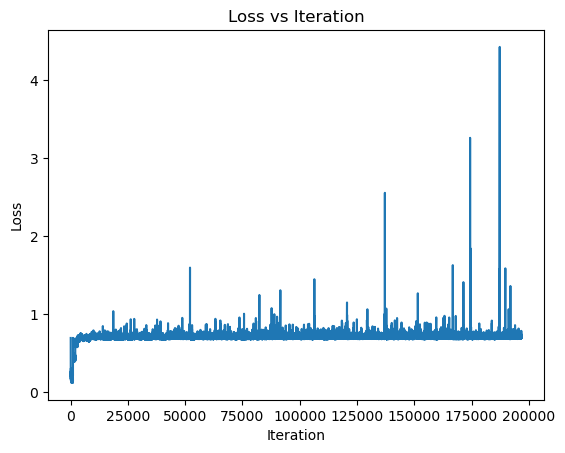

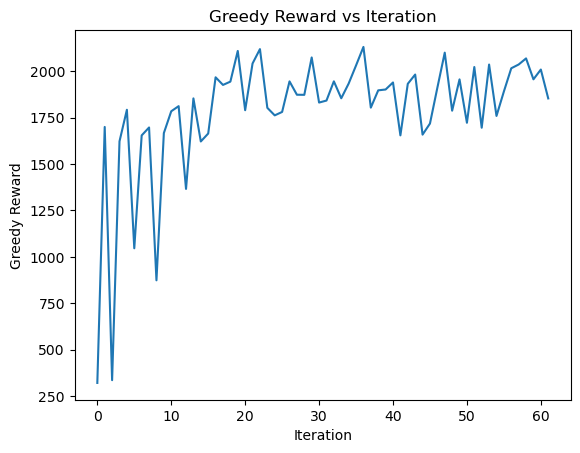

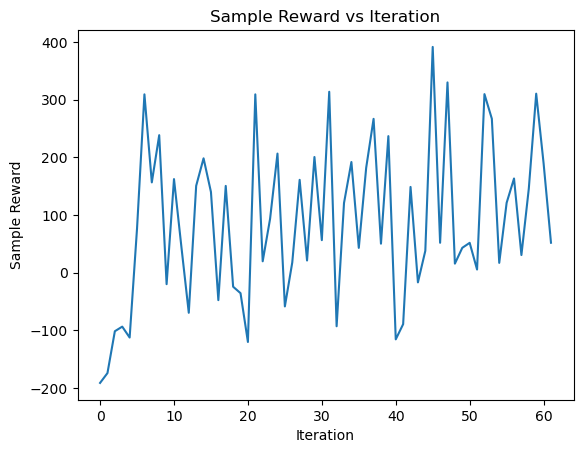

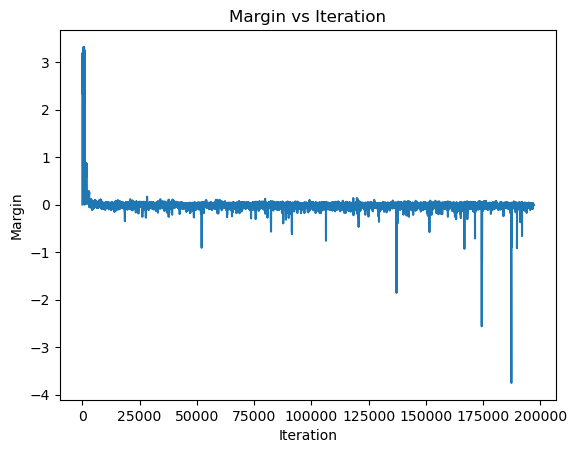

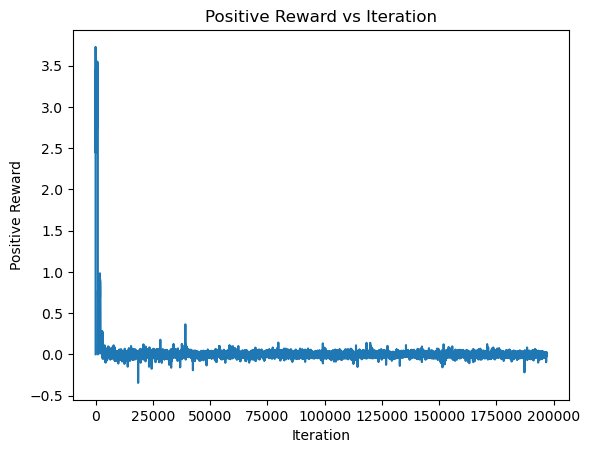

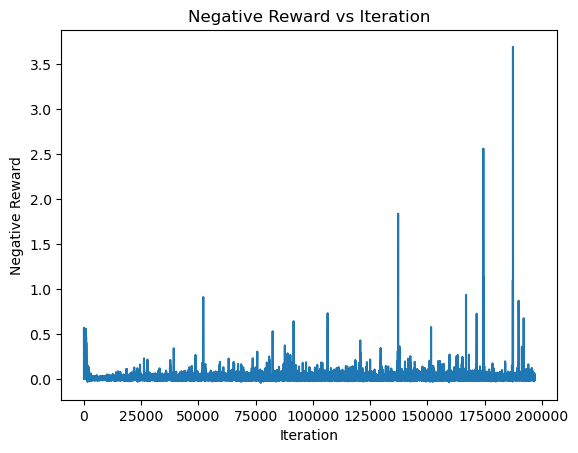

In [ ]:
# save all png to /mnt/nfs/work/albertliu/RL/CartPole-v1/DPO

# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(loss_graph)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs Iteration")
# plt.savefig("./loss.png")

plt.show()



# draw the reward graph
plt.plot(greedy_rewards)
plt.xlabel("Iteration")
plt.ylabel("Greedy Reward")
plt.title("Greedy Reward vs Iteration")
# plt.savefig("./greedy_reward.png")
plt.show()

# draw the reward graph
plt.plot(sample_rewards)
plt.xlabel("Iteration")
plt.ylabel("Sample Reward")
plt.title("Sample Reward vs Iteration")
# plt.savefig("./sample_reward.png")
plt.show()


# drqw the margin graph
plt.plot(margin_graph)
plt.xlabel("Iteration")
plt.ylabel("Margin")
plt.title("Margin vs Iteration")
# plt.savefig("./margin.png")
plt.show()

# draw the positive reward graph
plt.plot(positive_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Positive Reward")
plt.title("Positive Reward vs Iteration")
# plt.savefig("./positive_reward.png")
plt.show()

# draw the negative reward graph
plt.plot(negative_reward_graph)
plt.xlabel("Iteration")
plt.ylabel("Negative Reward")
plt.title("Negative Reward vs Iteration")

# plt.savefig("./negative_reward.png")
plt.show()


In [ ]:
# from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
# from stable_baselines3.common.vec_env import VecEnv
# import gymnasium as gym
# from imitation.policies.serialize import load_policy
# from imitation.util.util import make_vec_env
# import numpy as np
# import torch
# import os

# # 创建环境
# env = make_vec_env(
#     "seals:seals/Walker2d-v1",
#     rng=np.random.default_rng(),
#     n_envs=1,
#     env_make_kwargs={"render_mode": "rgb_array"},
# )

# # 使用 VecVideoRecorder 包装环境以启用视频记录，指定视频保存的路径
# video_folder = './videos'
# video_length = 200  # 设置视频长度
# env = VecVideoRecorder(env, video_folder,
#                        record_video_trigger=lambda step: step == 0, video_length=video_length,
#                        name_prefix="Walker2d-video")

# # 创建模型，这里以从 Hugging Face 加载预训练的 PPO 模型为例
# model = load_policy(
#     "ppo-huggingface",
#     organization="HumanCompatibleAI",
#     env_name="seals/Walker2d-v1",
#     venv=env,
# )

# # 训练模型
# # 注意: 此处假定模型已经预训练，无需再次训练

# # 测试模型，生成视频
# obs = env.reset()
# done = False
# while not done:
#     action, _states = model.predict(obs, deterministic=True)
#     obs, rewards, dones, info = env.step(action)
#     done = dones.any()

# env.close()

# # 如果需要手动保存视频（有时候视频不会在关闭时自动保存）
# env.record_video_trigger(video_length)


/mnt/nfs/work/c98181/miniconda3/envs/copy/lib/python3.9/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/mnt/nfs/work/c98181/miniconda3/envs/copy/lib/python3.9/site-packages/glfw/__init__.py:914: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


FatalError: gladLoadGL error